# Creating the Perfect Bracket

There's nothing quite like the most riveting basketball event of the year: NCAA March Madness. The 64-team tournament consists of 4 regions, each with 16 teams ranked independently of the other regions according to their regular season performance. Each team attempts to win 6 successive games in order to emerge victorious as the NCAA national champion.

Perhaps what contributes most to the intrigue of March Madness is filling out a March Madness bracket. "The American Gaming Association estimated in 2019 that 40 million Americans filled out a combined 149 million brackets for a collective wager of \\$4.6 billion." It's important to note that even a single bet can be quite lucrative, particularly when an upset occurs (when a lower-ranking underdog beats a higher-ranking favorite). For example, the first-ever upset of a #1 seed by a #16 seed occurred in the 2019 NCAA tournament. In that game "a \\$100 bet paid out \\$2,500", which translates to American betting odds of +2500!

<br>
All quotations were cited from the following article: <br>
https://www.gobankingrates.com/money/business/money-behind-march-madness-ncaa-basketball-tournament/

### Problem Structure

The purpose of this personal project is to perform supervised classification on March Madness data to more accurately predict the outcome of an NCAA tournament games--particularly the occurrence of upsets. This would allow for an increased possibility of yielding the kinds of profits mentioned above by filling out more accurate brackets relative to other participants.

In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
import re
from datetime import datetime
curr_year = datetime.now().year
import warnings
warnings.filterwarnings("ignore")

# Custom API
from data_fetch import get_team_data, get_rankings_data, get_coach_data, get_current_bracket
from data_pipeline import dataset_pipeline, feature_pipeline, bracket_pipeline
from data_clean import feature_null_counts, get_null_rows, clean_tourney_data, clean_round_cols
from data_visualizations import get_yearly_base_rates, get_seed_pairs, format_plot
from model_selection import get_cv_models
from model_evaluation import evaluate_cv_models, probs_to_preds, test_model_thresholds

# Data Fetching

### Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
<br>**Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won**

<br>And lastly, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (0-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?**

## Examples

### Team Regular Season Stats

In [2]:
get_team_data(url="https://www.sports-reference.com/cbb/seasons/1993-school-stats.html",
              attrs={'id': 'basic_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,409,584,.700,NaN,965,285,178,109,385,546
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,320,493,.649,NaN,795,316,163,47,352,573
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,456,650,.702,NaN,1273,501,246,135,498,650
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,541,767,.705,NaN,1049,393,194,42,556,567
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,458,702,.652,NaN,1117,337,185,120,487,539


In [3]:
get_team_data(url="https://www.sports-reference.com/cbb/seasons/1993-advanced-school-stats.html", 
              attrs={'id': 'adv_school_stats'}).head()

,Rk,School,G,W,L,W-L%,SRS,SOS,Unnamed: 8,W.1,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,1,Air Force,28,9,19,.321,-7.45,2.05,NaN,3,...,.279,.500,49.9,44.3,NaN,9.6,.458,17.4,NaN,.263
1,2,Akron,26,8,18,.308,-10.69,-5.07,NaN,3,...,.277,.517,51.1,54.5,NaN,5.5,.488,18.4,NaN,.241
2,3,Alabama-Birmingham,35,21,14,.600,10.82,5.68,NaN,5,...,.270,.527,52.2,56.4,NaN,9.6,.494,17.8,NaN,.228
3,4,Alabama State,27,14,13,.519,-8.48,-9.70,NaN,9,...,.203,.557,51.3,46.1,NaN,2.8,.518,20.7,NaN,.305
4,5,Alabama,29,16,13,.552,9.66,7.83,NaN,7,...,.299,.541,51.7,43.1,NaN,8.9,.513,19.4,NaN,.271


### Team Rankings

In [4]:
get_rankings_data(url="https://www.sports-reference.com/cbb/seasons/1993-ratings.html").head()

,Team,Top_25
2,North Carolina,1
3,Kentucky,1
4,Duke,1
5,Indiana,1
6,Cincinnati,1


### Coach Tournament Performance

In [5]:
get_coach_data(url='https://www.sports-reference.com/cbb/seasons/1993-coaches.html').head()

,Coach_Team,MM,S16,F4,Champs
2,Air Force,,,,
3,Akron,,,,
4,Alabama,,,,
5,Alabama-Birmingham,11,5,2,
6,Alabama State,,,,


### Tournament Game Data

In [6]:
get_team_data(url=("https://apps.washingtonpost.com/sports/search/?pri_school_id=&pri_conference=&pri_coach"
                   "=&pri_seed_from=1&pri_seed_to=16&pri_power_conference=&pri_bid_type=&opp_school_id"
                   "=&opp_conference=&opp_coach=&opp_seed_from=1&opp_seed_to=16&opp_power_conference=&opp_bid_type"
                   "=&game_type=7&from=1993&to=1993&submit="), 
              attrs={'class': 'search-results'}, header=0).head()

,Year,Round,Seed,Team,Score,Seed.1,Team.1,Score.1
0,1993,National ChampionshipNational Championship,1,Michigan Michigan,71,1,North Carolina North Carolina,77
1,1993,Final FourFinal Four,1,North Carolina North Carolina,78,2,Kansas Kansas,68
2,1993,Final FourFinal Four,1,Kentucky Kentucky,78,1,Michigan Michigan,81
3,1993,Elite EightElite Eight,1,North Carolina North Carolina,75,2,Cincinnati Cincinnati,68
4,1993,Elite EightElite Eight,1,Michigan Michigan,77,7,Temple Temple,72


# Data Cleaning

## Data Pipeline

In [7]:
try:
    mm_matchups_df = pd.read_csv('march_madness_hist_data.csv')
except FileNotFoundError:
    mm_matchups_df = dataset_pipeline(np.arange(1993, curr_year - 1))
    mm_matchups_df.to_csv('march_madness_hist_data.csv', index=False)

mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,W-L%_Favorite,SOS_Favorite,FG%_Favorite,...,FG/Game_Underdog,3P/Game_Underdog,FT/Game_Underdog,ORB/Game_Underdog,TRB/Game_Underdog,AST/Game_Underdog,STL/Game_Underdog,BLK/Game_Underdog,TOV/Game_Underdog,PF/Game_Underdog
0,1993,National Championship,1,North Carolina,1,Michigan,0,0.895,11.25,0.506,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
1,1993,Final Four,1,Kentucky,1,Michigan,1,0.882,9.23,0.480,...,31.4,4.2,14.9,NaN,41.5,16.3,6.8,5.4,15.6,18.6
2,1993,Final Four,1,North Carolina,2,Kansas,0,0.895,11.25,0.506,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
3,1993,Elite Eight,1,Indiana,2,Kansas,1,0.886,11.09,0.522,...,30.8,6.0,16.8,NaN,36.1,19.1,9.1,2.9,14.5,17.6
4,1993,Elite Eight,1,North Carolina,2,Cincinnati,0,0.895,11.25,0.506,...,28.1,5.0,13.2,NaN,36.0,16.0,10.0,2.6,14.1,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,2019,First Round,6,Maryland,11,Belmont,0,0.676,10.09,0.449,...,31.6,10.4,13.4,8.7,38.6,19.5,6.7,3.8,11.4,15.4
1743,2019,First Round,6,Buffalo,11,Arizona State,0,0.889,2.62,0.462,...,26.4,7.1,17.6,11.7,39.7,13.5,6.3,3.2,13.7,19.9
1744,2019,Play-In,11,Belmont,11,Temple,0,0.818,-2.60,0.498,...,26.5,7.5,14.3,9.6,34.4,14.4,8.6,2.2,11.2,17.6
1745,2019,Play-In,16,North Dakota State,16,North Carolina Central,0,0.543,-2.07,0.454,...,25.7,6.5,13.5,11.7,37.2,15.5,6.1,2.7,15.1,17.9


## Handling Missing Values

### Finding the Nulls

In [8]:
true_nulls = feature_null_counts(mm_matchups_df)
true_nulls

Pace_Underdog        1072
Pace_Favorite        1065
STL%_Favorite         766
ORB%_Favorite         766
ORtg_Favorite         766
STL%_Underdog         765
ORtg_Underdog         765
ORB%_Underdog         764
ORB/Game_Underdog     255
ORB/Game_Favorite     254
PF/Game_Underdog       64
PF/Game_Favorite       64
TOV/Game_Underdog       3
TOV%_Underdog           3
TOV/Game_Favorite       1
TOV%_Favorite           1
dtype: int64

In [9]:
tov_null_fills = [col for col in true_nulls.index if ('TOV' in col)]
pf_null_fills = [col for col in true_nulls.index if ('PF' in col)]

null_drops = list(set(true_nulls.index) - set(tov_null_fills) - set(pf_null_fills))
mm_matchups_df.drop(null_drops, axis=1, inplace=True)

In [10]:
tov_nulls_rows = get_null_rows(tov_null_fills, mm_matchups_df)
pf_nulls_rows = get_null_rows(pf_null_fills, mm_matchups_df)

display(tov_nulls_rows), display(pf_nulls_rows)

,Year,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
15,1993,NaN,NaN,15.6,17.4
16,1993,NaN,NaN,12.0,15.9
42,1993,17.8,16.6,NaN,NaN
470,2000,NaN,NaN,15.8,17.8


,Year,PF/Game_Underdog,PF/Game_Favorite
568,2002,NaN,NaN
569,2002,NaN,NaN
570,2002,NaN,NaN
571,2002,NaN,NaN
572,2002,NaN,NaN
...,...,...,...
627,2002,NaN,NaN
628,2002,NaN,NaN
629,2002,NaN,NaN
630,2002,NaN,NaN


(None, None)

### What are the Distributions of the Features We Wish to Impute?

1993 feature distributions
2000 feature distributions


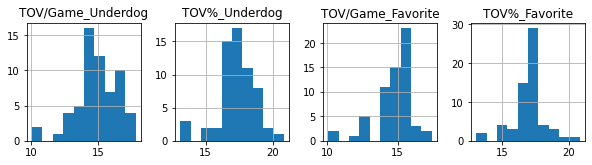

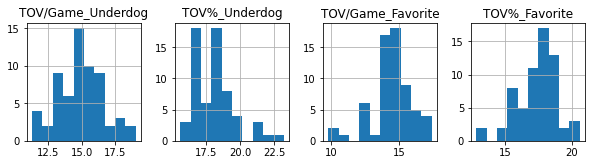

In [11]:
tov_null_years = sorted(list(set(tov_nulls_rows['Year'])))

for year in tov_null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[tov_null_fills].hist(figsize=(10, 5), layout=(len(tov_null_years), len(tov_null_fills)))

array([[<AxesSubplot:title={'center':'PF/Game_Underdog'}>,
        <AxesSubplot:title={'center':'PF/Game_Favorite'}>]], dtype=object)

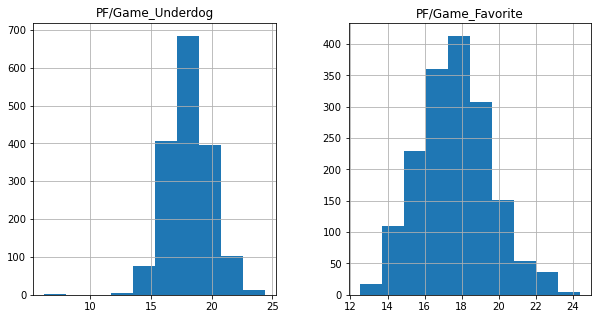

In [12]:
mm_matchups_df[pf_null_fills].hist(figsize=(10, 5), layout=(1, len(pf_null_fills)))

### Impute TOV Nulls by Season

In [13]:
tov_col_means = mm_matchups_df[tov_nulls_rows.columns].groupby('Year').mean()
tov_col_means.loc[tov_null_years]

,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
Year,,,,
1993,14.909836,17.281967,14.787097,17.066129
2000,14.916129,18.106452,14.520635,17.384127


In [14]:
for year in tov_null_years:
    for col in tov_null_fills:
        col_fill_rows = tov_nulls_rows[tov_nulls_rows['Year'] == year].index
        col_year_mean = np.round(tov_col_means.loc[year, col], 1)
        
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)
        
mm_matchups_df.loc[tov_nulls_rows.index, tov_null_fills]

,TOV/Game_Underdog,TOV%_Underdog,TOV/Game_Favorite,TOV%_Favorite
15,14.9,17.3,15.6,17.4
16,14.9,17.3,12.0,15.9
42,17.8,16.6,14.8,17.1
470,14.9,18.1,15.8,17.8


### Impute PF Nulls Using Entire Distribution

In [15]:
pf_col_means = mm_matchups_df[pf_null_fills].mean()
pf_col_means

PF/Game_Underdog    18.108200
PF/Game_Favorite    17.634759
dtype: float64

In [16]:
for col in pf_null_fills:
    col_mean = np.round(mm_matchups_df[col].mean(), 1)
    mm_matchups_df[col].fillna(col_mean, inplace=True)
    
mm_matchups_df.loc[pf_nulls_rows.index, pf_null_fills]

,PF/Game_Underdog,PF/Game_Favorite
568,18.1,17.6
569,18.1,17.6
570,18.1,17.6
571,18.1,17.6
572,18.1,17.6
...,...,...
627,18.1,17.6
628,18.1,17.6
629,18.1,17.6
630,18.1,17.6


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA

## What is a Bracket's Accuracy Given Random Guessing in Favor of the Majority Class (Base Rate: Favorite Beats Underdog)?

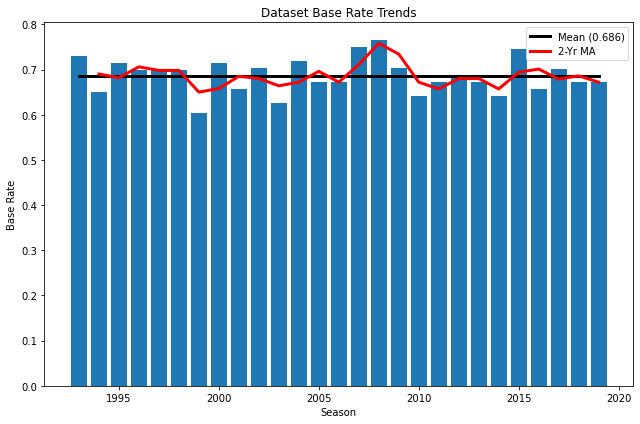

In [17]:
yearly_base_rates = get_yearly_base_rates(mm_matchups_df)
mean_base_rate = np.round(yearly_base_rates.mean(), 3)

years_ma = 2
base_rate_ma = np.round(yearly_base_rates.rolling(years_ma).mean(), 3)

plt.figure(figsize=(9, 6))

plt.plot(yearly_base_rates.index, [mean_base_rate] * len(yearly_base_rates), color='k', linewidth=3, label=f'Mean ({mean_base_rate})')
plt.plot(yearly_base_rates.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rates.index, yearly_base_rates)

format_plot(title='Dataset Base Rate Trends', xlabel='Season', ylabel='Base Rate')

## How Often Do Upsets Occur in a Given Year's March Madness? 

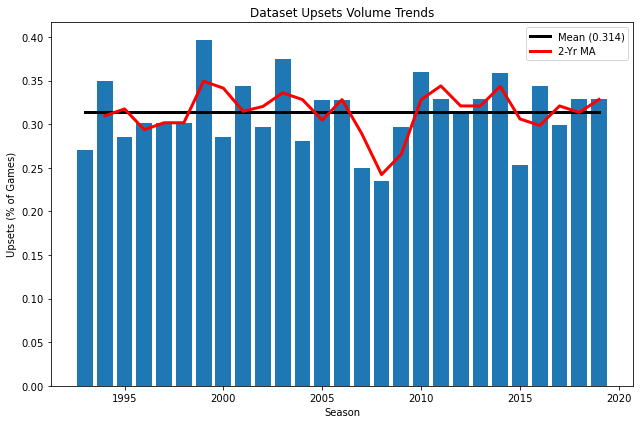

In [18]:
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': ['sum', 'count']})
yearly_pct_upsets = yearly_upsets[('Underdog_Upset',   'sum')] / yearly_upsets[('Underdog_Upset',   'count')]

pct_upsets_ma = yearly_pct_upsets.rolling(years_ma).mean()
mean_pct_upsets = np.round(yearly_pct_upsets.mean(), 3)

plt.figure(figsize=(9, 6))

plt.plot(yearly_pct_upsets.index, [mean_pct_upsets] * len(yearly_pct_upsets), color='k', linewidth=3, 
         label=f'Mean ({mean_pct_upsets})')
plt.plot(yearly_pct_upsets.index, pct_upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_pct_upsets.index, yearly_pct_upsets)

format_plot(title='Dataset Upsets Volume Trends', xlabel='Season', ylabel='Upsets (% of Games)')

## What is the Distribution of Upsets Across Each Tournament Round?

In [19]:
seed_pairs = get_seed_pairs(mm_matchups_df)

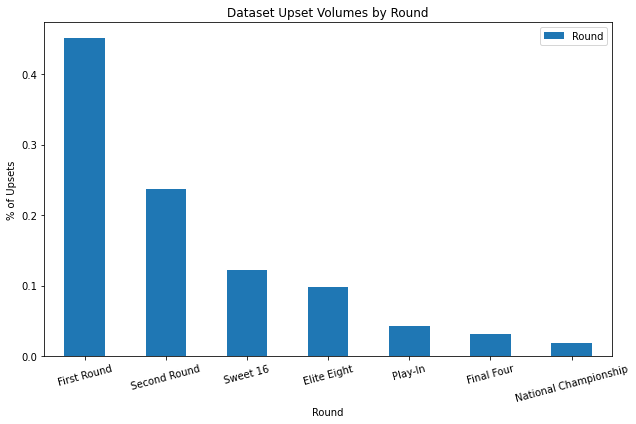

In [20]:
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]
upset_rounds_freq = upset_pairs['Round'].value_counts(normalize=True)
upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Dataset Upset Volumes by Round', xlabel='Round', ylabel='% of Upsets')

## Which Seeding Combinations are the Most Likely to Produce Upsets?

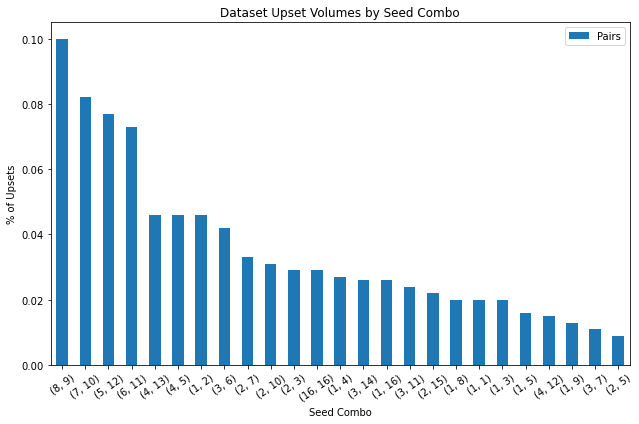

In [21]:
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)
upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Dataset Upset Volumes by Seed Combo', xlabel='Seed Combo', ylabel='% of Upsets')

# Feature Engineering & Analysis

In [22]:
all_rounds = mm_matchups_df['Round']
mm_matchups_df.drop(['Year', 'Team_Favorite', 'Team_Underdog'], axis=1, inplace=True)

scaled_mm_matchups_df = feature_pipeline(mm_matchups_df)
X = scaled_mm_matchups_df.drop('Underdog_Upset', axis=1)
y = scaled_mm_matchups_df['Underdog_Upset']

display(X), display(y)

,Round,Seed_Favorite,Seed_Underdog,Underdog_Rel_AST%,Underdog_Rel_W-L%,Underdog_Rel_Champs,Underdog_Rel_FG%,Underdog_Rel_3P%,Underdog_Rel_3P/Game,Underdog_Rel_TRB%,...,Underdog_Rel_TRB/Game,Underdog_Rel_BLK/Game,Underdog_Rel_TS%,Underdog_Rel_STL/Game,Underdog_Rel_F4,Underdog_Rel_PF/Game,Underdog_Rel_MM,Underdog_Rel_PtsDiff,Underdog_Rel_3PAr,Underdog_Rel_S16
0,3.413099,-0.955849,-2.254069,-0.658690,0.365335,-0.602478,0.082917,-0.439580,-0.067535,0.069754,...,0.448947,1.275685,-0.265956,-1.258251,-1.607594,0.930980,-1.586351,-0.736854,-0.077424,-2.199983
1,2.589752,-0.955849,-2.254069,-1.556309,0.474286,1.330541,0.926045,-1.026308,-3.143463,0.702403,...,0.712625,0.739070,-0.538374,-1.308877,0.772175,-1.871262,0.516262,-0.718710,-2.919638,0.536851
2,2.589752,-0.955849,-2.002255,0.789081,-0.095609,-1.568988,0.634193,1.107248,0.921156,-0.984661,...,-0.974915,-0.214912,0.944793,-0.093835,-1.947561,0.530659,-1.586351,0.097796,0.677754,-2.371035
3,1.766404,-0.955849,-2.002255,0.745648,-0.020182,-2.535498,0.115345,-0.306233,0.262029,0.220385,...,0.211637,0.381327,0.036731,1.526222,-0.587693,0.490627,-0.922368,0.623988,0.169725,-1.344722
4,1.766404,-0.955849,-2.002255,0.079673,0.222862,-1.568988,-0.825067,-1.186325,0.371883,-0.532769,...,-1.001283,-0.393784,-0.871330,0.361806,-2.287528,0.890947,-1.697015,0.333675,0.856250,-2.371035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,-0.703640,0.751932,0.264065,1.541922,1.840359,0.364032,1.931313,0.760545,1.745065,-0.803904,...,0.158901,-0.274536,1.883124,1.222461,0.432208,-0.229949,0.405599,1.948542,0.856250,0.194747
1743,-0.703640,0.751932,0.264065,-0.484958,-1.134831,0.364032,-0.144079,0.120478,-1.330862,0.401141,...,0.053430,-0.095664,-0.265956,-0.448222,0.432208,0.450595,0.516262,-1.045312,-1.217055,0.536851
1744,-1.526987,2.459712,0.264065,-0.948245,-0.363796,0.364032,-1.635767,-0.972969,-1.550572,-0.864156,...,-0.763972,-0.632279,-1.809661,1.019954,0.432208,0.690787,1.512237,-1.117890,-1.011098,0.536851
1745,-1.526987,4.167492,1.523132,2.178942,0.532952,0.364032,0.374769,-1.079647,-1.605499,2.178583,...,1.820074,0.440950,-0.659449,0.817447,0.432208,1.011044,0.737590,1.458638,-1.628970,0.536851


0       0
1       1
2       0
3       1
4       0
       ..
1742    0
1743    0
1744    0
1745    0
1746    0
Name: Underdog_Upset, Length: 1747, dtype: int64

(None, None)

## What are the Distributions of all our Engineered Features?

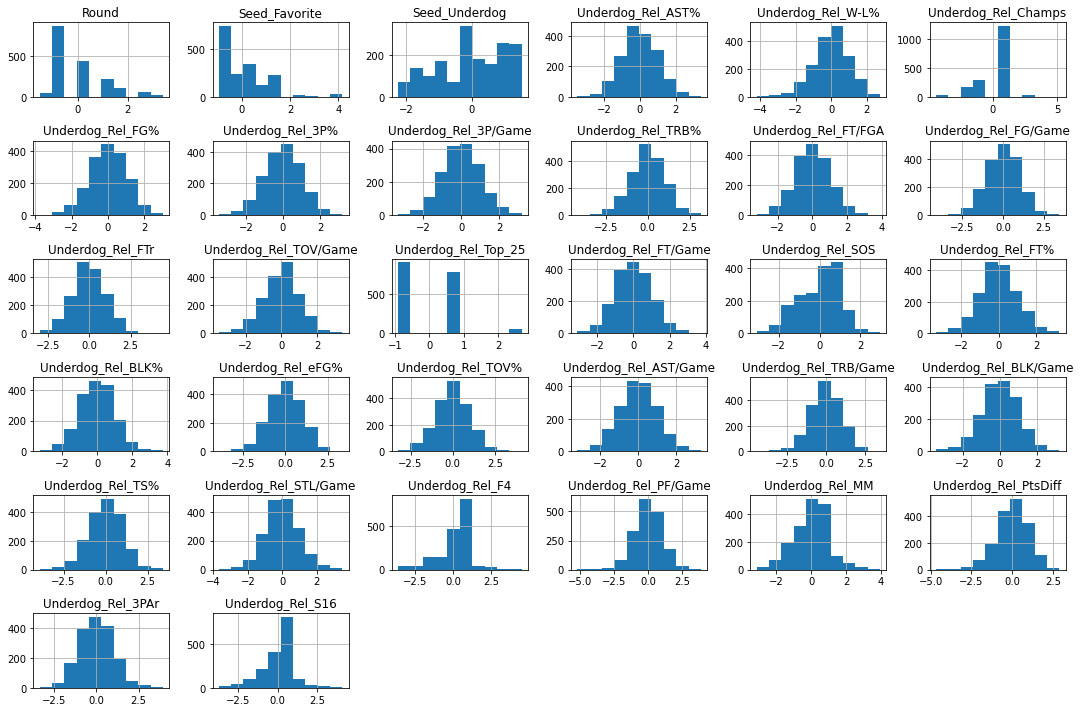

In [23]:
X.hist(figsize=(15, 10))
plt.tight_layout()

## What are the Correlations Between Features?

No handles with labels found to put in legend.


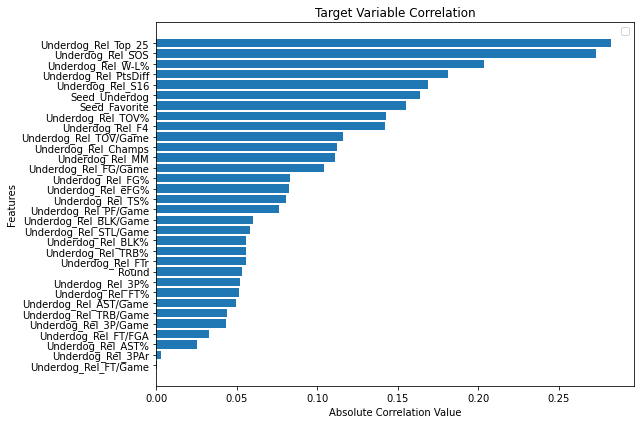

In [24]:
abs_desc_corr = np.abs(scaled_mm_matchups_df.corr().loc['Underdog_Upset']).sort_values()
abs_desc_corr.drop('Underdog_Upset', inplace=True)

plt.figure(figsize=(9, 6))
plt.barh(abs_desc_corr.index, abs_desc_corr.values)

format_plot(title='Target Variable Correlation', xlabel='Absolute Correlation Value', ylabel='Features')

## What Features have the Greatest Predictive Power?

No handles with labels found to put in legend.


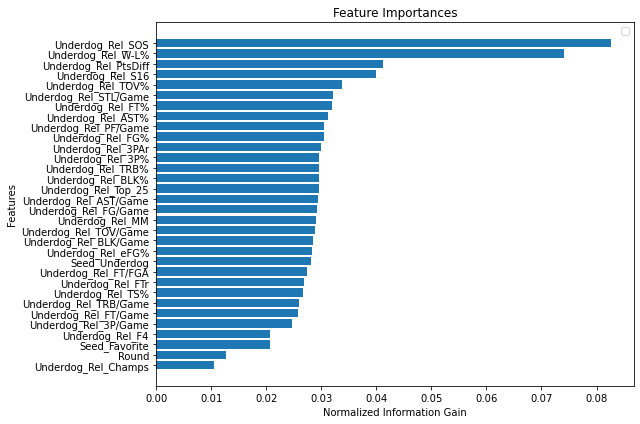

In [25]:
rf = RandomForestClassifier().fit(X, y)

# Sort features & their corresponding values in by importance
importances = rf.feature_importances_
feat_importances = X.columns[np.argsort(importances)]
feat_values = np.sort(importances)

# Plot feature importances calculated above
plt.figure(figsize=(9, 6))
plt.barh(feat_importances, feat_values)

format_plot(title='Feature Importances', xlabel='Normalized Information Gain', ylabel='Features')

# Model Selection

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.drop('Round', axis=1, inplace=True)
X_test.drop('Round', axis=1, inplace=True)

cv_models = get_cv_models(y)
model_performance = evaluate_cv_models(cv_models, X_train, y_train)

model_performance

,Mean_Accuracy,Mean_Accuracy_Std,Mean_AUC,Mean_AUC_Std
KNN,0.690,0.008,0.667,0.022
Naive Bayes,0.654,0.041,0.696,0.031
LogReg,0.732,0.005,0.748,0.024
SVM,0.728,0.011,0.749,0.024
Random Forest,0.700,0.007,0.691,0.020


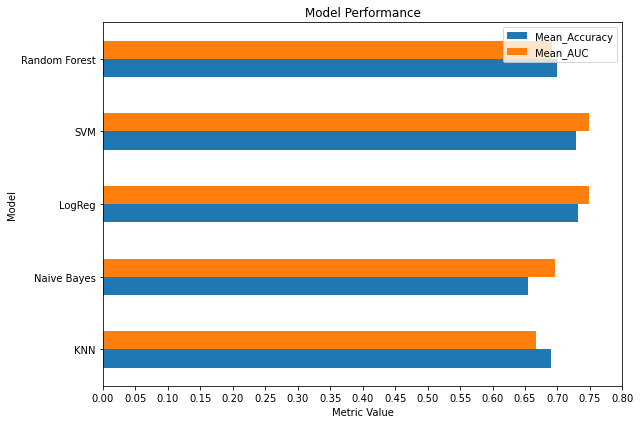

In [27]:
model_performance[['Mean_Accuracy', 'Mean_AUC']].plot(figsize=(9, 6), kind='barh', xticks=np.arange(0, 0.85, 0.05))

format_plot(title='Model Performance', xlabel='Metric Value', ylabel='Model')

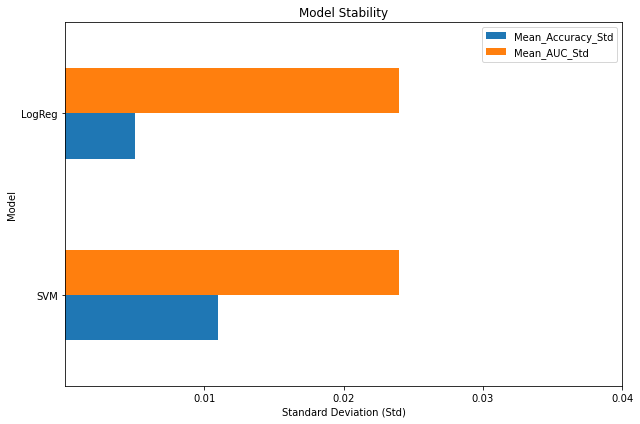

In [28]:
model_performance.loc[['SVM', 'LogReg'], ['Mean_Accuracy_Std', 'Mean_AUC_Std']].plot(
    figsize=(9, 6), kind='barh', xticks=np.arange(0.01, 0.05, 0.01)
)

format_plot(title='Model Stability', xlabel='Standard Deviation (Std)', ylabel='Model')

In [29]:
print(f"Best SVM Score: {np.round(cv_models['SVM'][-1].best_score_, 3)}")
print(f"Best LogReg Score: {np.round(cv_models['LogReg'][-1].best_score_, 3)}")

Best SVM Score: 0.766
Best LogReg Score: 0.775


# Model Evaluation

In [30]:
best_model = cv_models['LogReg'][-1].best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]

evaluation_df = test_model_thresholds(y_test, y_probs, np.arange(0, 1, 0.005))

display(best_model), display(evaluation_df)

LogisticRegression(C=1, max_iter=500, random_state=42)

,Accuracy,AUC,Upsets (%)
0.000,0.314,0.500,1.000
0.005,0.326,0.508,0.989
0.010,0.337,0.517,0.977
0.015,0.340,0.519,0.974
0.020,0.346,0.520,0.963
...,...,...,...
0.845,0.700,0.523,0.014
0.865,0.697,0.518,0.011
0.875,0.694,0.514,0.009
0.880,0.689,0.505,0.003


(None, None)

In [31]:
auc_best_thresh = evaluation_df['AUC'].idxmax()
acc_best_thresh = evaluation_df['Accuracy'].idxmax()
best_threshs = {
    'Accuracy': acc_best_thresh,
    'AUC': auc_best_thresh,
}

best_thresh_performance = evaluation_df.loc[[evaluation_df.iloc[-1].name] + list(best_threshs.values())]
best_thresh_performance

,Accuracy,AUC,Upsets (%)
0.995,0.686,0.500,0.000
0.480,0.797,0.736,0.249
0.355,0.763,0.766,0.409


In [32]:
test_game_data = pd.concat([y_test, all_rounds, mm_matchups_df[['Seed_Favorite', 'Seed_Underdog']]], 
                           join='inner', axis=1).drop('Underdog_Upset', axis=1)
test_game_data['Underdog_Upset'] = probs_to_preds(y_probs, auc_best_thresh)

test_seed_pairs = get_seed_pairs(test_game_data)

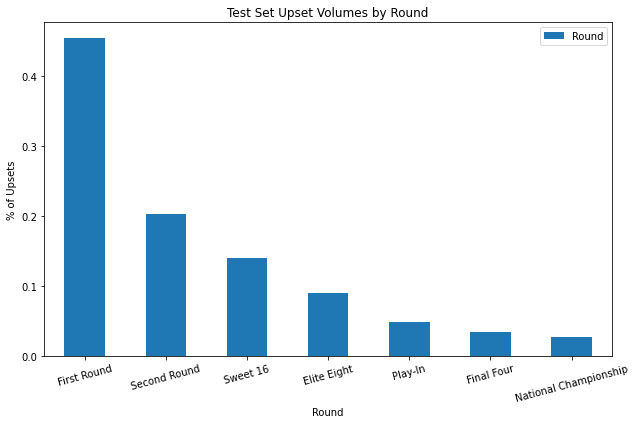

In [33]:
test_upset_pairs = test_seed_pairs[test_seed_pairs['Underdog_Upset'] == 1]
test_upset_rounds_freq = test_upset_pairs['Round'].value_counts(normalize=True)
test_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Test Set Upset Volumes by Round', xlabel='Round', ylabel='% of Upsets')

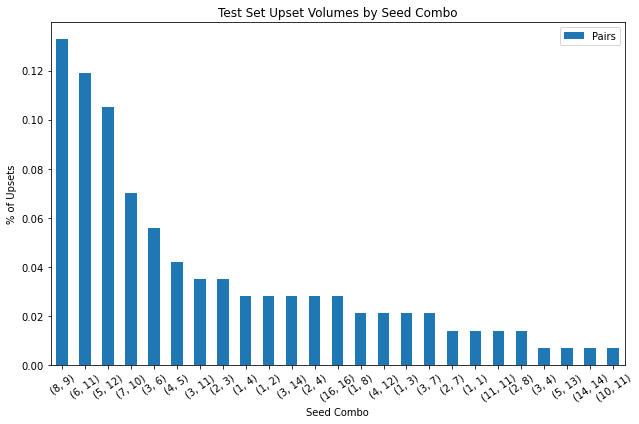

In [34]:
test_upset_pairs_freq = np.round(test_upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)
test_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Test Set Upset Volumes by Seed Combo', xlabel='Seed Combo', ylabel='% of Upsets')

# 2021 March Madness Predictions

## Data Pipeline

In [35]:
try:
    curr_bracket_df = pd.read_csv('march_madness_curr_start_bracket.csv')
except FileNotFoundError:
    curr_bracket_df = get_current_bracket('http://www.espn.com/mens-college-basketball/tournament/bracket')
    curr_bracket_df.to_csv('march_madness_curr_start_bracket.csv', index=False)

play_in = curr_bracket_df[:4]
play_in = play_in.reindex([0, 1, 3, 2])

first_round = curr_bracket_df[4:]
first_round.index = range(len(first_round))

display(play_in), display(first_round)

,Seed,Team,Seed.1,Team.1
0,16,Norfolk St,16.0,Appalachian State
1,11,Wichita State,11.0,Drake
3,16,Mount St. Mary's,16.0,Texas Southern
2,11,Michigan State,11.0,UCLA


,Seed,Team,Seed.1,Team.1
0,1,Gonzaga,NaN,NaN
1,8,Oklahoma,9.0,Missouri
2,5,Creighton,12.0,UC Santa Barbara
3,4,Virginia,13.0,Ohio
4,6,USC,NaN,NaN
5,3,Kansas,14.0,Eastern Washington
6,7,Oregon,10.0,VCU
7,2,Iowa,15.0,Grand Canyon
8,1,Michigan,NaN,NaN
9,8,LSU,9.0,St. Bonaventure


(None, None)

In [36]:
bracket_by_metric = {}

for metric, thresh in best_threshs.items():
    play_in_copy = play_in.copy()
    first_round_copy = first_round.copy()
    
    for df in [play_in_copy, first_round_copy]:
        clean_round_cols(df)
        
    bracket_preds = bracket_pipeline(curr_year, play_in_copy, first_round_copy, best_model, thresh, null_drops)
    bracket_by_metric[metric] = bracket_preds

    display(bracket_preds)

,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
0,16,16,Norfolk St,Appalachian State,0,0,Norfolk St
1,11,11,Drake,Wichita State,0,1,Wichita State
2,16,16,Texas Southern,Mount St. Mary's,0,0,Texas Southern
3,11,11,UCLA,Michigan State,0,0,UCLA
4,1,16,Gonzaga,Norfolk St,1,0,Gonzaga
...,...,...,...,...,...,...,...
62,14,8,Colgate,North Carolina,4,0,Colgate
63,1,7,Illinois,Clemson,4,0,Illinois
64,1,1,Gonzaga,Michigan,5,0,Gonzaga
65,1,14,Illinois,Colgate,5,0,Illinois


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
0,16,16,Norfolk St,Appalachian State,0,1,Appalachian State
1,11,11,Drake,Wichita State,0,1,Wichita State
2,16,16,Texas Southern,Mount St. Mary's,0,0,Texas Southern
3,11,11,UCLA,Michigan State,0,0,UCLA
4,1,16,Gonzaga,Appalachian State,1,0,Gonzaga
...,...,...,...,...,...,...,...
62,14,8,Colgate,North Carolina,4,0,Colgate
63,1,11,Illinois,Syracuse,4,0,Illinois
64,1,4,Michigan,Virginia,5,0,Michigan
65,1,14,Illinois,Colgate,5,1,Colgate


## Pre-Tournament Model Evaluation

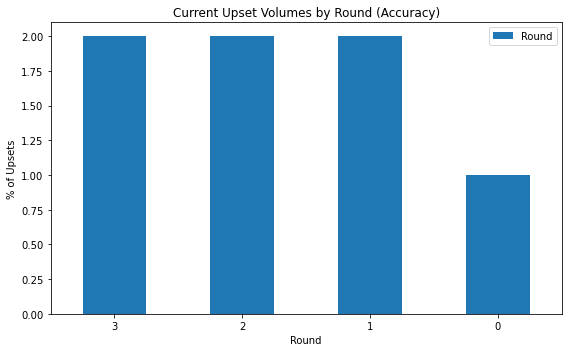

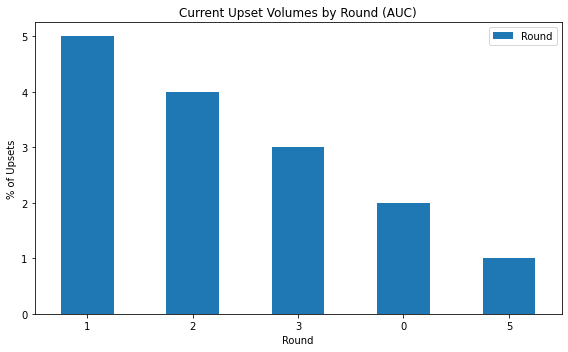

In [37]:
for metric, bracket_preds in bracket_by_metric.items():
    curr_seed_pairs = get_seed_pairs(bracket_preds)
    curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]
    
    plt.figure()

    curr_upset_rounds_freq = curr_upset_pairs['Round'].value_counts()
    curr_upset_rounds_freq.plot(figsize=(8, 5), kind='bar', rot=0)

    format_plot(title=f'Current Upset Volumes by Round ({metric})', xlabel='Round', ylabel='% of Upsets')

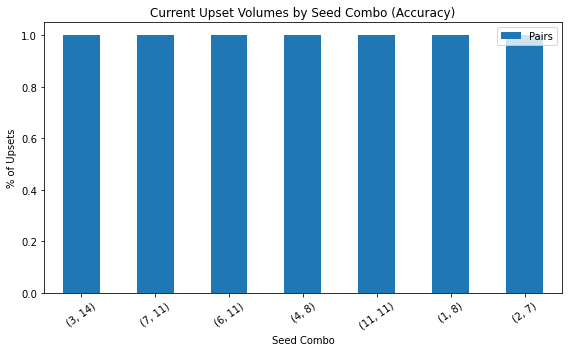

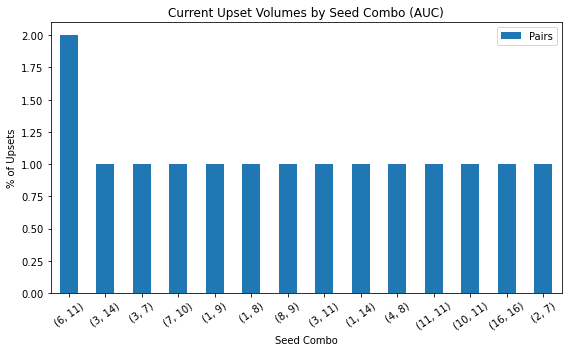

In [38]:
for metric, bracket_preds in bracket_by_metric.items():
    curr_seed_pairs = get_seed_pairs(bracket_preds)
    curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]
    
    plt.figure()

    curr_upset_pairs_freq = curr_upset_pairs['Pairs'].value_counts()
    curr_upset_pairs_freq.plot(figsize=(8, 5), kind='bar', rot=35)

    format_plot(title=f'Current Upset Volumes by Seed Combo ({metric})', xlabel='Seed Combo', ylabel='% of Upsets')

In [39]:
best_bracket = bracket_by_metric['AUC']

for round_num in range(7):
    display(best_bracket[best_bracket['Round'] == round_num])

,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
0,16,16,Norfolk St,Appalachian State,0,1,Appalachian State
1,11,11,Drake,Wichita State,0,1,Wichita State
2,16,16,Texas Southern,Mount St. Mary's,0,0,Texas Southern
3,11,11,UCLA,Michigan State,0,0,UCLA


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
4,1,16,Gonzaga,Appalachian State,1,0,Gonzaga
5,8,9,Oklahoma,Missouri,1,1,Missouri
6,5,12,Creighton,UC Santa Barbara,1,0,Creighton
7,4,13,Virginia,Ohio,1,0,Virginia
8,6,11,USC,Wichita State,1,1,Wichita State
9,3,14,Kansas,Eastern Washington,1,0,Kansas
10,7,10,Oregon,VCU,1,0,Oregon
11,2,15,Iowa,Grand Canyon,1,0,Iowa
12,1,16,Michigan,Texas Southern,1,0,Michigan
13,8,9,LSU,St. Bonaventure,1,0,LSU


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
36,1,9,Gonzaga,Missouri,2,1,Missouri
37,4,5,Virginia,Creighton,2,0,Virginia
38,11,3,Wichita State,Kansas,2,1,Kansas
39,2,7,Iowa,Oregon,2,1,Oregon
40,1,8,Michigan,LSU,2,0,Michigan
41,4,5,Florida State,Colorado,2,0,Florida State
42,3,6,Texas,BYU,2,0,Texas
43,2,7,Alabama,UConn,2,0,Alabama
44,1,8,Baylor,North Carolina,2,1,North Carolina
45,4,5,Purdue,Villanova,2,0,Purdue


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
52,4,9,Virginia,Missouri,3,0,Virginia
53,3,7,Kansas,Oregon,3,1,Oregon
54,1,4,Michigan,Florida State,3,0,Michigan
55,2,3,Alabama,Texas,3,0,Alabama
56,4,8,Purdue,North Carolina,3,1,North Carolina
57,14,2,Colgate,Ohio State,3,0,Colgate
58,1,4,Illinois,Oklahoma State,3,0,Illinois
59,10,11,Rutgers,Syracuse,3,1,Syracuse


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
60,4,7,Virginia,Oregon,4,0,Virginia
61,1,2,Michigan,Alabama,4,0,Michigan
62,14,8,Colgate,North Carolina,4,0,Colgate
63,1,11,Illinois,Syracuse,4,0,Illinois


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
64,1,4,Michigan,Virginia,5,0,Michigan
65,1,14,Illinois,Colgate,5,1,Colgate


,Seed_Favorite,Seed_Underdog,Team_Favorite,Team_Underdog,Round,Underdog_Upset,Winner
66,1,14,Michigan,Colgate,6,0,Michigan
